In [1]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# section : Mathematical intuituion for vanilla r2.
* Hand calculating and verifying with sklearn.metrics.r2 
* showing R2 as square of pearson-r (correlation) .!! Only for 1 regressor 1 response model (univariate Regression)
* Showing how to perform worse than y_avg line to get a negative R2 score

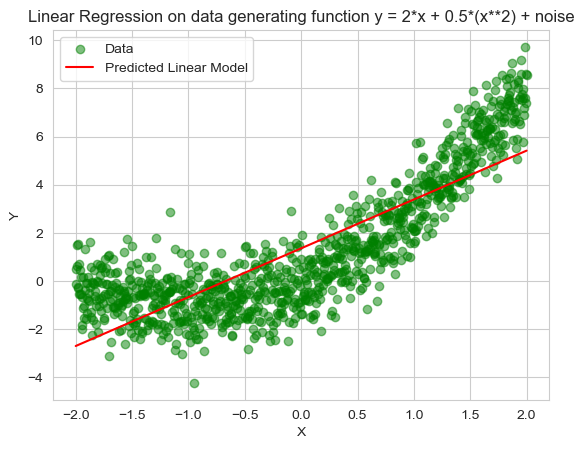

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

np.random.seed(42)

# settings
sample_size = int(1e3)
noise = np.random.randn(sample_size)
x = np.linspace(-2, 2, sample_size)
# ground truth . we will only use x as a regressor . not x^2 ; so its a line
y = 2*x + 1*(x**2) + noise  # so that it does not fit perfectly

x_reshape = x.reshape(-1, 1) # turn it into column variable

# linear regression
model = LinearRegression()
model.fit(x_reshape, y)

y_pred = model.predict(x_reshape)

fig, ax = plt.subplot_mosaic("A")
ax['A'].scatter(x, y, alpha=0.5, label='Data',color="green")
ax['A'].plot(x, y_pred, color='red', label='Predicted Linear Model')
ax['A'].legend()
ax['A'].set_xlabel('X')
ax['A'].set_ylabel('Y')
ax['A'].set_title('Linear Regression on data generating function y = 2*x + 0.5*(x**2) + noise')

plt.show()


In [3]:
# so the data generating function was y = 2*x + 0.5*(x**2) + noise
# linear regression with a single regressor 'x' was y = 2.03 x + 0.69
print(f"y = {model.intercept_} + {model.coef_}*x")

y = 1.355334725158328 + [2.03004599]*x


In [4]:
# hand calculating
rss = np.sum((y - y_pred)**2)
tss = np.sum((y - np.average(y))**2)
r2 = 1 - (rss/tss)
r2

0.6956270314147173

In [5]:
# verifying and showing the squared relation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
print(f"r2 score from sklearn :{ r2_score(y,y_pred):.8}")
print(f"r2 score as squared of correlation: { pearsonr(y,x)[0]**2:.8}")

r2 score from sklearn :0.69562703
r2 score as squared of correlation: 0.69562703


In [6]:
# show how to get negative r2 score
# i.e suppose a model was very bad
y_bad = np.ones_like(y) * 1e4
# then
print(f"R2 score when model performs worse than y_avg model {r2_score(y,y_bad)}")

R2 score when model performs worse than y_avg model -12631055.33086728


# Monte Carlo Simulation
* R2 increases with increase in number of regressors
* R2 remains the same even with a lot of noise variables introduced in the model. 
* Thereby showing why vanilla R2 is not used for subset selection
* Starting to introduce alternatives

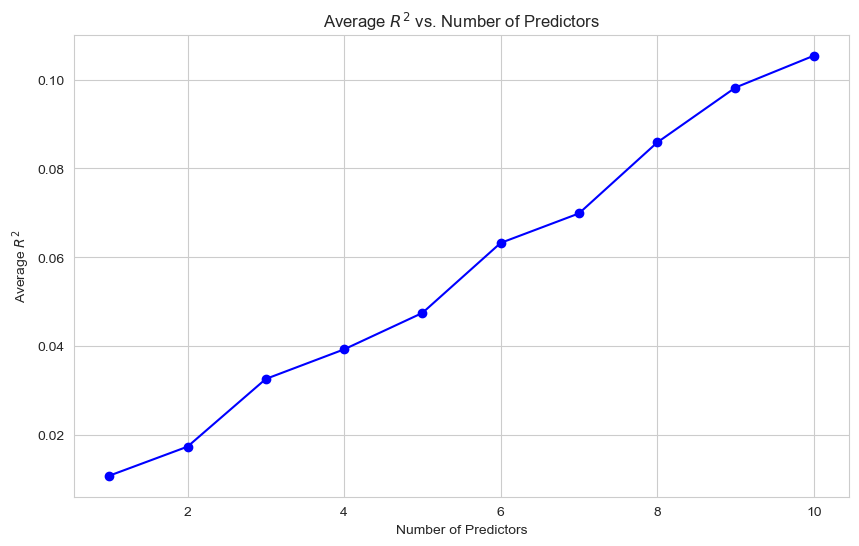

In [7]:
# Settings
np.random.seed(42)
n_obs = 100
max_predictors = 10
iterations = 100
# initialize r2 score
r2_scores = np.zeros(max_predictors)

for n_predictors in range(1, max_predictors + 1):
    r2_iter = []
    for _ in range(iterations):
        X = np.random.randn(n_obs, n_predictors) # note how we made x's random and not really dependent on Y
        Y = np.random.randn(n_obs)
        model = LinearRegression().fit(X, Y)
        Y_pred = model.predict(X)
        r2_iter.append(r2_score(Y, Y_pred))
    r2_scores[n_predictors - 1] = np.mean(r2_iter)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_predictors + 1), r2_scores, marker='o', linestyle='-', color='blue')
plt.title('Average $R^2$ vs. Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Average $R^2$')
plt.grid(True)
plt.show()


In [8]:
# adjusted r2 gets more prominant when the sample size is not that high
# and the model tries to add a lot of noise variables to predict it
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# sample size
sample_size = 20
noise = np.random.randn(sample_size)
x = np.linspace(-3, 3, sample_size)
y = 2*x + 3*(x**4) + noise # the data generating function depends on the 4th power

# Constant noise variables. they can only capture intercpet . 
# so this will not help reducing r2. R2 would remain constant as we add more of these noise variables
c1 = np.full_like(x, 2)
c2 = np.full_like(x, 4)
c3 = np.full_like(x, 5)
c4 = np.full_like(x, 8)

c5 = np.full_like(x, 2.5)
c6 = np.full_like(x, 4.5)
c7 = np.full_like(x, 5.5)
c8 = np.full_like(x, 8.5)


# Design Matrices

X =  np.column_stack((x, x**4)) # model with perfect assumption

# With noise
X_with_noise = np.column_stack((x, x**4, c1, c2, c3, c4,c5,c6,c7,c8))

# Initialize and fit models
lin_model = LinearRegression()
lin_model_noise = LinearRegression()

lin_model.fit(X, y)
lin_model_noise.fit(X_with_noise, y)

# Calculate R^2 scores
r_act = r2_score(y, lin_model.predict(X))
r_noise = r2_score(y, lin_model_noise.predict(X_with_noise))

# so this is just terrible for feature selection
print("They are the same with vanilla R2!! :",r_act == r_noise, r_act)

# lets look the coefficients of the 2 modesls
print(lin_model.intercept_ , lin_model.coef_)
print(lin_model_noise.intercept_ , lin_model_noise.coef_) # notice how const noise coefs are just 0. as it just needed 1 const to capture intercept

They are the same with vanilla R2!! : True 0.9998548065999432
-0.30482749739554293 [1.95037783 3.01080202]
-0.30482749739554293 [1.95037783 3.01080202 0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [9]:
# Inspiration : lets see how one of the proposed method does on the same data. we will look into it more. in the code cells below
def adjusted_r2(r2,n,d):
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - d - 1))
    return adjusted_r2

adjusted_r2_act = adjusted_r2(r_act,20,2)
adjusted_r2_noise = adjusted_r2(r_noise,20,10)

# now it can tell the differnce between the 2 models 
print("Is now the actual model better :",adjusted_r2_act > adjusted_r2_noise)
print(f"{adjusted_r2_act=:.8}, {adjusted_r2_noise=:.8}")

Is now the actual model better : True
adjusted_r2_act=0.99983773, adjusted_r2_noise=0.99969348


# Performing adjusted methods on the real world dataset
* Mallow's Cp
* Bayes Information Criteria
* Adjusted R2

In [10]:
# credit dataset
import statsmodels.api as sm,pandas as pd
credit_data = sm.datasets.get_rdataset("Credit", "ISLR")
credit = pd.DataFrame(credit_data.data)
credit.drop(columns="ID",inplace=True)
credit

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,Male,No,Yes,Caucasian,560
396,13.364,3838,296,5,65,17,Male,No,No,African American,480
397,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
398,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0


<Axes: >

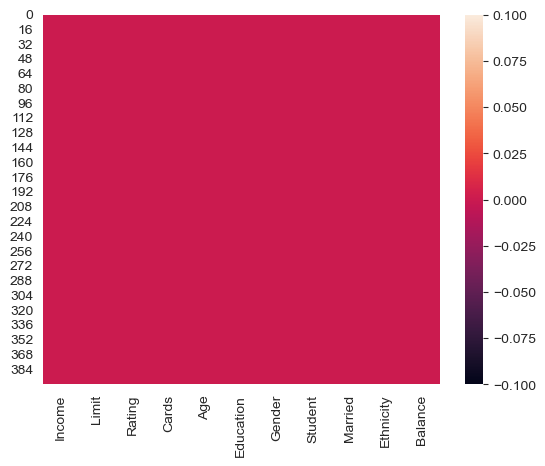

In [11]:
import seaborn as sns
sns.heatmap(credit.isnull())

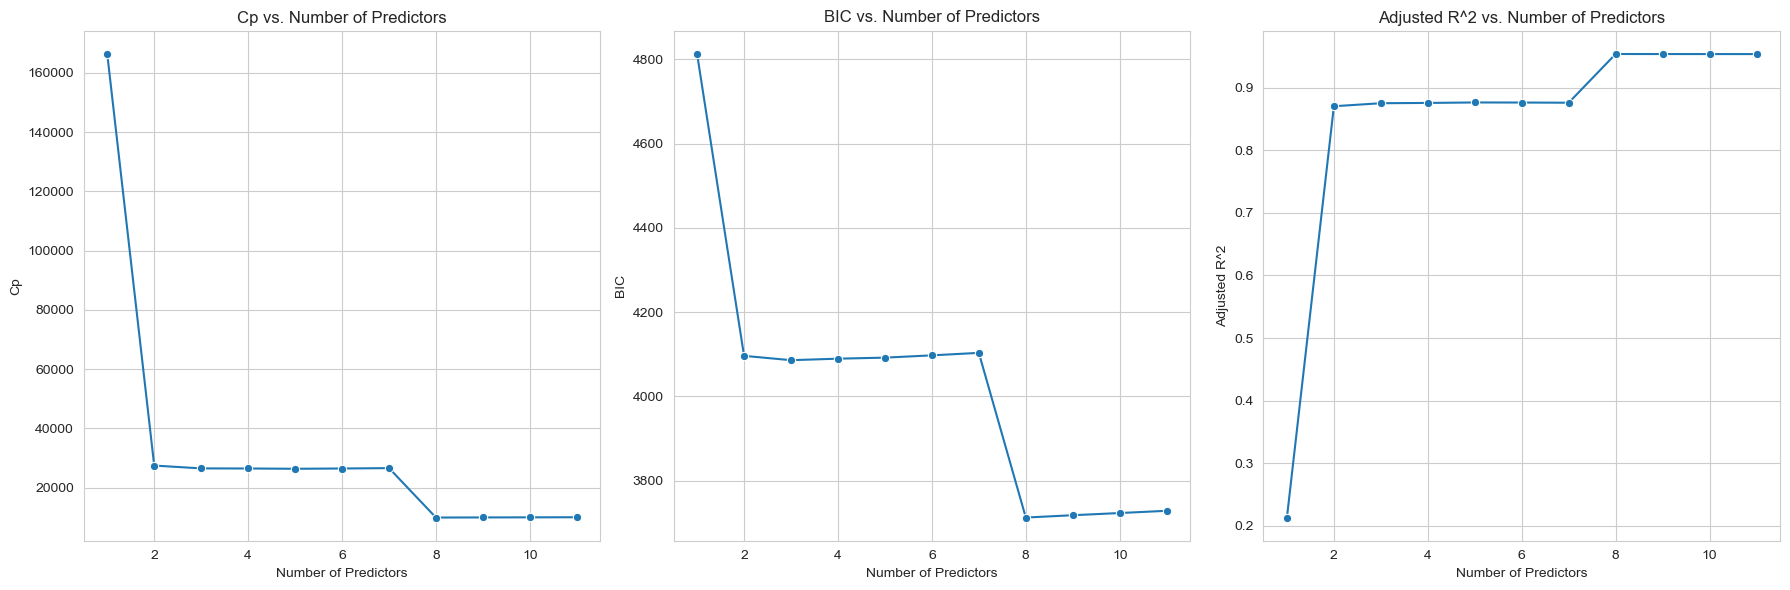

In [12]:
# credit dataset with vanilla r2 and proposed methods
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
label_encoder = LabelEncoder()

# Label encoding for binary categorical variables
binary_columns = ['Gender', 'Student', 'Married']  # Specify the binary categorical columns

# Apply label encoder to each binary categorical column
for col in binary_columns:
    credit[col] = label_encoder.fit_transform(credit[col])

# One-hot encoding for non-binary categorical variables
credit = pd.get_dummies(credit, columns=['Ethnicity'], drop_first=True)


# Assuming 'credit_data' is a pandas DataFrame with the correct data
X = credit.drop(['Balance'], axis=1)  # Replace 'Outcome_Variable' with the actual name of your outcome variable
y = credit['Balance']

# Initialize lists to store the values for plotting
cp_values = []
bic_values = []
adjusted_r2_values = []
vanilla_r2 = []

# Looping over subsets of predictors
for i in range(1, len(X.columns) + 1):
    # Select the first i predictors
    X_subset = X.iloc[:, :i]

    # cross validation to get an idea of generalization performance
    model = LinearRegression()
    mse_scores = cross_val_score(model, X_subset, y, cv=10, scoring='neg_mean_squared_error')

    # Convert MSE scores to positive values. General Practice
    mse_scores = -mse_scores

    # Calculate Cp, BIC, and Adjusted R2 (using training data for simplicity)
    model.fit(X_subset, y)
    RSS = np.sum((y - model.predict(X_subset)) ** 2)
    TSS = np.sum((y - np.mean(y)) ** 2)
    sigma_hat_squared = RSS / (len(y) - i - 1)
    cp = (RSS + 2 * i * sigma_hat_squared) / len(y)
    bic = len(y) * np.log(RSS/len(y)) + i * np.log(len(y))
    adjusted_r2 = 1 - (RSS/(len(y)-i-1)) / (TSS/(len(y)-1))
    r2 = r2_score(y,model.predict(X_subset))
    
    vanilla_r2.append(r2)
    cp_values.append(cp)
    bic_values.append(bic)
    adjusted_r2_values.append(adjusted_r2)

plt.figure(figsize=(18, 6))

# Cp plot
plt.subplot(1, 3, 1)
sns.lineplot(x=range(1, len(X.columns) + 1), y=cp_values, marker='o')
plt.title('Cp vs. Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Cp')

# BIC plot
plt.subplot(1, 3, 2)
sns.lineplot(x=range(1, len(X.columns) + 1), y=bic_values, marker='o')
plt.title('BIC vs. Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC')

# Adjusted R^2 plot
plt.subplot(1, 3, 3)
sns.lineplot(x=range(1, len(X.columns) + 1), y=adjusted_r2_values, marker='o')
plt.title('Adjusted R^2 vs. Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Adjusted R^2')

plt.tight_layout()
plt.show()


# validates result from the book

![Alt text](islr_results.png "ISLR Page 237")


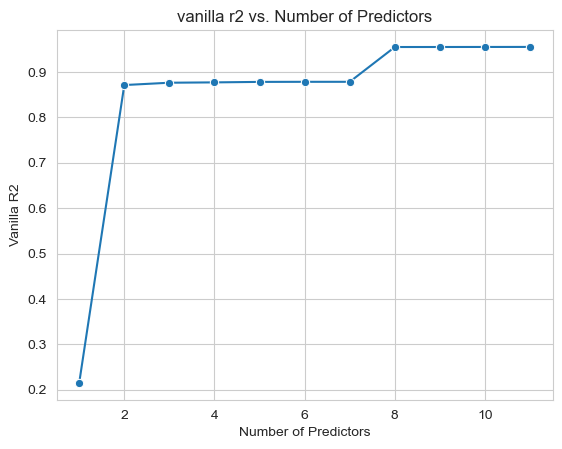

In [13]:
# while vanilla r2 was
sns.lineplot(x=range(1, len(X.columns) + 1), y=vanilla_r2, marker='o')
plt.title('vanilla r2 vs. Number of Predictors')
plt.xlabel('Number of Predictors')
plt.ylabel('Vanilla R2')
plt.show()